In [1]:
import collections
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st

# Numba to make things faster
import numba

# The MCMC Hammer
import emcee

# Numerical differentiation package
import numdifftools as ndt

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import corner


# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}


# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2,
      'axes.labelsize': 18,
      'axes.titlesize': 18,
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import datetime as dt


# Fetch Data and Standardize Results to prepare for MCMC


      Death rate
      mean: 0.522186
      stdev: 0.231825
      max: 1.000000
      min: 0.061224
      
before:  (87, 9)
after:  (84, 9)


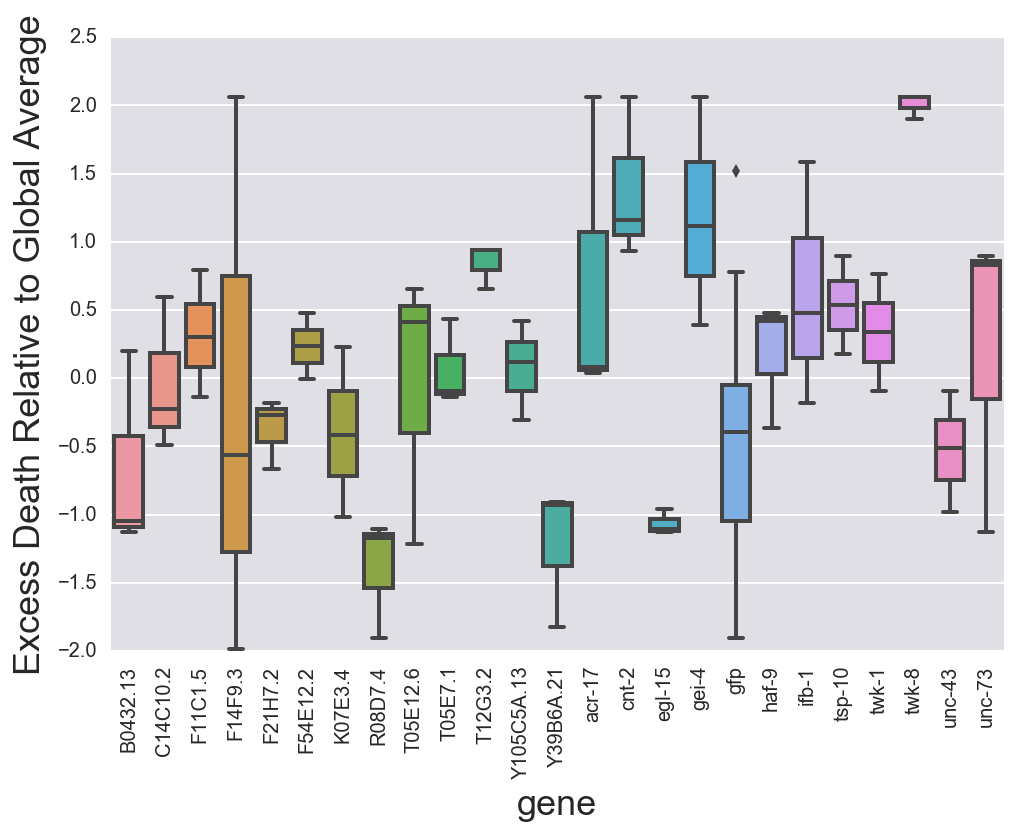

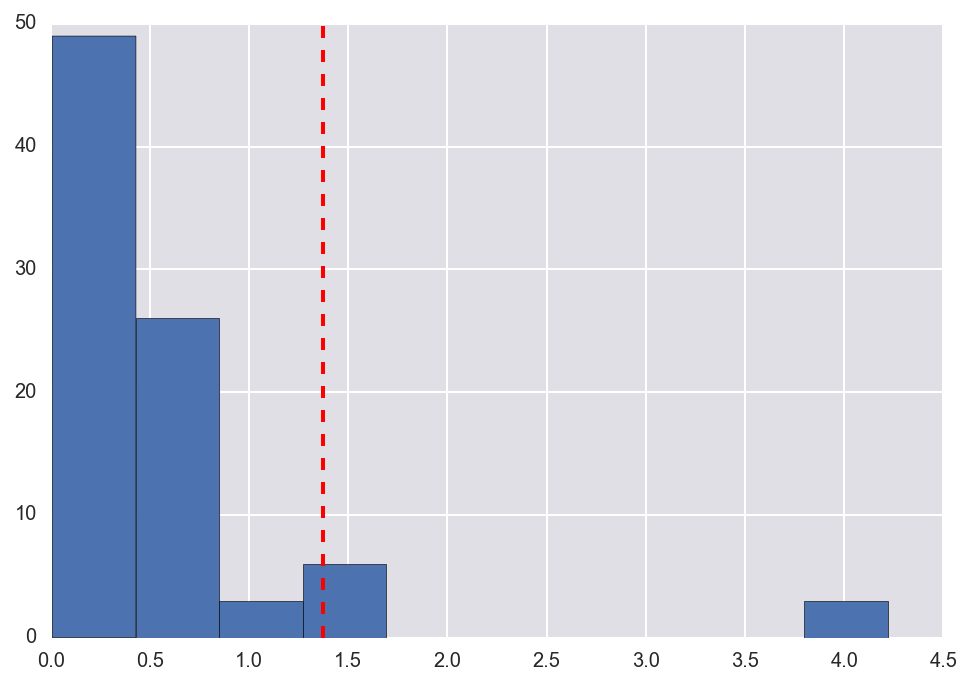

In [71]:
input_path = '../input/rnai_screen_results/'
output_path = '../output/rnai_screen_results/'

df = pd.read_csv(input_path + 'rnai_heat_shock_data.csv', sep=',')
names = pd.read_csv(input_path + 'rnai_genes_dict.csv')

# rename the columns to something handy
df.columns = ['rnai', 'alive', 'dead', 'date']

# make all codes upper or lower, not both
# first make sure each column is a str
names.code = names.code.apply(str)
df.rnai = df.rnai.apply(str)
# now apply lower
names.code = names.code.apply(str.lower)
df.rnai = df.rnai.apply(str.lower)

# extract the names that have been assayed so far
def translate(x):
    """A function to go between rnai code and gene (human-readable) name."""
    return names[names.code == x].gene_name.values[0]

df['gene'] = df.rnai.apply(translate)

df['long_date'] = df.date.apply(lambda x: 
                                dt.datetime.strptime(x,'%Y-%m-%d'))
df.sort_values(['gene', 'long_date'], inplace=True)

# calculate fraction dead
df['fraction_dead'] = df.dead/(df.alive + df.dead)
print("""
      Death rate
      mean: {0:2f}
      stdev: {1:2f}
      max: {2:2f}
      min: {3:2f}
      """.format(df.fraction_dead.mean(), df.fraction_dead.std(), 
                 df.fraction_dead.max(), df.fraction_dead.min()
                )
     )

# standardize dead values to the mean and stdev of the gfp data
fr_dead_mu = df.fraction_dead.mean()
fr_dead_sig = df.fraction_dead.std()
total = (df.dead+df.alive)

df['z_dead'] = (df.dead - total*fr_dead_mu)/(fr_dead_sig*total)

sns.boxplot(x='gene', y='z_dead', data=df)
plt.ylabel('Excess Death Relative to Global Average')
plt.xticks(rotation=90)


def var_by_gene(x):
    return df[df.gene == x].z_dead.var()

df['var_by_gene'] = df.gene.apply(var_by_gene)
fig, ax = plt.subplots()
plt.hist(df.var_by_gene)
plt.axvline(df.var_by_gene.mean()+df.var_by_gene.std(), ls='--', color='r')
to_drop = df[df.var_by_gene > df.var_by_gene.mean() + df.var_by_gene.std()].gene
to_drop

labels = df.gene.isin(to_drop.unique())
print('before: ', df.shape)
df.drop(df[labels].index, inplace=True)
print('after: ', df.shape)

$$
z_{dead} = \frac{w_{\mathrm{dead}}- w_\mathrm{t}\cdot p_d}{p_d\cdot p_a \cdot w_\mathrm{t}}
$$

$$
z_{dead} = \frac{p_{\mathrm{obs, dead}}- p_d}{p_d\cdot p_a}
$$

In [ ]:
p_d = np.array([0.5, 0.522])

p_obs = np.linspace(0, 1, 1000)

def z_dead(p, p_d):
    """
    params:
    -------
    p - an input vector between 0, 1
    p_d - a scalar between 0, 1
    """
    z_dead = (p - p_d)/(p_d*(1-p_d))
    
    return z_dead

z = np.empty((len(p_d), len(p_obs)))

for i, val in enumerate(p_d):
    z[i] = z_dead(p_obs, val)

plt.plot(p_obs, z[0], 'k')
plt.plot(p_obs, z[1], 'b')

zmax = np.max(z)
zmin = np.min(z)
plt.ylim(zmin-0.01, zmax +0.01)
# plt.yscale('symlog')

In [ ]:
# by date
sns.factorplot(x='date', y='z_dead', data=df[df.gene=='gfp'])
plt.xticks(rotation=90)
# plt.rotation()



# df[(df.gene == 'gfp')& (df.date == '12-May-16') ].head()
# plt.hist(df[(df.gene == 'gfp')& (df.date == '12-May-16')].fraction_dead, alpha=0.5)
# plt.hist(df[(df.gene == 'gfp')& (df.date == '13-May-16')].fraction_dead, alpha=0.5)
# plt.hist(df[(df.gene == 'gfp')& (df.date == '16-May-16')].fraction_dead, alpha=0.5)


# Toy MCMC to make sure I can implement justin's good-bad model (i.e., not hierarchical)

In [ ]:
def log_posterior_good_bad(p, x):
    """
    The log posterior for the good/bad data model for repeated
    measurements.
    
    params:
    -------
    p - the parameters. First three params must be mu, sigma, and sigma_bad
    x - data to fit the model to
    
    output:
    log_prior + log_like - a scalar number
    """
    # Pull out parameters
    mu, sigma, sigma_bad = p[:3]
    g = p[3:]
        
    # Check to make sure the prior conditions are ok    
    if (g < 0.0).any() or (g > 1.0).any() or sigma <= 0.0 \
            or sigma_bad < sigma:
        return -np.inf

    # log prior
    log_prior = -np.log(sigma) - np.log(sigma_bad)
    
    # Add in likelihood
    log_like_good = np.log((1-g) / sigma) - ((x - mu) / sigma)**2 / 2.0
    log_like_bad = np.log(g / sigma_bad) \
                        - ((x - mu) / sigma_bad)**2 / 2.0
    log_like = np.logaddexp(log_like_good, log_like_bad).sum()
    
    # Return the whole posterior
    return log_prior + log_like - np.sum(g)


In [ ]:
def mcmc(target, n_walkers=200, n_burn=2000, n_steps=5000, df=df):
    """
    A wrapper around the emcee sampler for easy MCMCs.
    
    This wrapper function takes in a dataframe containing information
    on a few different genes. The user must specify which gene is 
    targeted, this gene is then analyzed using a good-bad posterior.
    params:
    -------
    target -- a string that specifies which gene to draw data from
    n_walkers -- number of walkers
    n_burn -- number of burn-in steps
    n_steps -- number of steps post-burn-in
    df -- the df to take data from
    """
    
    if target not in df.gene.unique():
        raise ValueError('target must be in df.gene.unique')
    
    n_dim = 3 + len(df[df.gene == target])  # number of parameters in the model
    
    med_val = df[df.gene == target].z_dead.median()
    
    # Seed random number generator for reproducibility
    np.random.seed(42)

    # Generate random starting points for walkers.
    # p0[i,j] is the starting point for walk i along variable j.
    p0 = np.empty((n_walkers, n_dim))
    p0[:, 0] = np.random.normal(med_val, 0.1, n_walkers)                # mu
    p0[:, 1] = np.random.exponential(1.0, n_walkers)               # sigma
    p0[:, 2] = np.random.exponential(5.0, n_walkers)              # sigma_bad
    p0[:, 3:] = np.random.uniform(0.0, 1.0, (n_walkers, n_dim-3))  # g_i

    # Set up the EnsembleSampler instance
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior_good_bad,
                                args=(df[df.gene == target].z_dead,),
                                threads=6)

    # Do the burn-in
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

    # Reset sampler and run from the burn-in state we got to
    _ = sampler.run_mcmc(pos, n_steps)
    
    return sampler


In [ ]:
def fetch_params(sampler):
    """A function that, given an emcee sampler, takes out the likeliest mean, sem and sigma."""
    max_ind = np.argmax(sampler.flatlnprobability)
    mean_goodbad = sampler.flatchain[max_ind, 0]
    sigma = sampler.flatchain[max_ind, 1]
    # Get the error bar
    sem_goodbad = sampler.flatchain[:, 0].std()
    
    return mean_goodbad, sigma, sem_goodbad

# That seemed to work. Now, set up a parallel mcmc function to calculate good-bad values for each strain -- this is approaching the level of unpacking required for us to deploy a full hierarchical model

In [ ]:
def parallel_log_posterior_good_bad(P, df):
    """
    The log posterior for the good/bad data model for repeated
    measurements under different conditions
    
    params:
    -------
    P - the parameters for all conditions. First n values are
    mu, n-2n are sigma, 2n-3n are sigma_bad. Rest are g's
    df - dataframe containing only the conditions to be used
    
    output:
    -------
    log_prior + log_like - a scalar number
    """
    grouped = df.groupby('gene')
    
    t_len = len(target)
    
    lp = 0
    
    n_data = 0
    i = 0
    for name, group in grouped:
        
        #extract the data
        x = group.z_dead

        data_points = len(group)
        
        #extract correct parameter set
        mu = P[i]
        sigma = P[t_len + i]
        sigma_bad = P[2*t_len + i]
        g = P[3*t_len+n_data: 3*t_len+n_data+data_points]
        
        if len(g) != len(x):
            raise ValueError('g must be same length as x')        
        
        p = np.array([mu, sigma, sigma_bad])
        p = np.concatenate((p, g))
        
        #update the parameter indices
        n_data += data_points  
        i += 1
                      
        #update log posterior
        lp += log_posterior_good_bad(p, x)
 

    return lp


In [ ]:
def parallel_mcmc(target, n_walkers=200, n_burn=2000, n_steps=5000, df=df):
    """
    A wrapper around the emcee sampler for easy MCMCs.
    Given a set of target genes, calculate the good_bad model for each. 
    
    This wrapper function takes in a dataframe containing information
    on a few different genes. The user must specify which gene is 
    targeted, this gene is then analyzed using a good-bad posterior.

    params:
    -------
    target -- a string that specifies which gene to draw data from
    n_walkers -- number of walkers
    n_burn -- number of burn-in steps
    n_steps -- number of steps post-burn-in
    df -- the df to take data from
    """
    
    for t in target:
        if t not in df.gene.unique():
            print(t)
            raise ValueError('all targets must be in df.gene.unique')
    
    df1 = df[df.gene.isin(target)]
    grouped = df1.groupby('gene')
    
    if type(target) is str:
        target = [target]
        

    n_dim = 3*len(target) + len(df1)  # number of parameters in the model
    n_walkers = 200 + 2*n_dim
    
    # Seed random number generator for reproducibility
    np.random.seed(42)
    
    # Generate random starting points for walkers.
    # p0[i,j] is the starting point for walk i along variable j.
    p0 = np.empty((n_walkers, n_dim))
    
    i = 0 
    n_data = 0
    n_data_tot = len(df1)
    t_len = len(target)
    
    for name, group in grouped:
        
        med_val = group.z_dead.median()
        data_points = len(group)
        
        
        p0[:, i] = np.random.normal(med_val, 0.1, n_walkers)                # mu
        p0[:, t_len + i] = np.random.exponential(1.0, n_walkers)               # sigma
        p0[:, 2*t_len+i] = np.random.exponential(5.0, n_walkers)              # sigma_bad
        
        # there's a different number of data points for each assay so...
        g_i= np.random.uniform(0.0, 1.0, (n_walkers, data_points))  # g_i
        
        p0[:, 3*t_len+n_data: 3*t_len+n_data+data_points] = g_i
        
        n_data += data_points
        i += 1

    # Set up the EnsembleSampler instance
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, parallel_log_posterior_good_bad,
                                args=(df1,),
                                threads=6)

    # Do the burn-in
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

    # Reset sampler and run from the burn-in state we got to
    _ = sampler.run_mcmc(pos, n_steps)
    
    return sampler


In [ ]:
def parallel_fetch_params(sampler, target, df=df):
    """A function that, given an emcee sampler, takes out the likeliest mean, sem and sigma."""
    l = len(target)
    
    max_ind = np.argmax(sampler.flatlnprobability)
    
    
    mean_goodbad = np.array([sampler.flatchain[max_ind, 0: l]])
    sigma = np.array([sampler.flatchain[max_ind, l: 2*l]])
    # Get the error bar
    sem_goodbad = np.empty(l)
    for i in range(0, l):
        sem_goodbad[i] = sampler.flatchain[:, i].std()
        
    t= np.array([target])

    t = np.concatenate((t, mean_goodbad, sigma))
    print(t.shape)
    print(sem.shape)
    t = np.concatenate((t, np.array([sem_goodbad])))
    return t

# Try out your parallelized MCMC

This MCMC will ascertain the true mean of each gene RNAi accounting for outliers.
Note:

There are multiple rnai codes that correspond to a single gene.

In [ ]:
target = df.gene.unique()
sampler = parallel_mcmc(target, df=df)

In [ ]:
d = parallel_fetch_params(sampler, target)

# df contains mean, sigma and sem(mean) of each gene (note, not rnai, there are multiple
# rnai per gene) as a result of the parallelized MCMC we just ran

# place data in a df, coerce to numeric bc numpy matrix was mixed type (str, np.floats)
ind = np.linspace(0, len(target) -1 , len(target)).astype(int)
df_mcmc= pd.DataFrame(index= ind, data=d.T, columns=['target_gene', 'mean_survival', 'sigma', 'sm'])
df_mcmc[['mean_survival', 'sigma', 'sm']] = df_mcmc[['mean_survival',
                                                     'sigma', 'sm']].apply(lambda x: 
                                                                           pd.to_numeric(x, errors='coerce'))

# Prepare for pseudo-hierarchical MCMC -- ie running an MCMC on the afore-calculated means

In [ ]:
# my function isn't perfect yet, so for the moment add a placeholder column called 'gene'
# in reality, this column is just so that we can do a second MCMC on the means of each gene
df_mcmc['gene'] = 'z'

# Before proceeding, plot out the data with and without 'outliers' (crudely defined for the moment)
# to ensure they look roughly gaussian, purely as a sanity check
fig, ax = plt.subplots()
sns.distplot(df_mcmc[df_mcmc.gene == 'z'].mean_survival)
plt.title('Distribution of Mean Survival, All Data')
plt.xlim(-2, 2)

fig, ax = plt.subplots()
sns.distplot(df_mcmc[(df_mcmc.gene == 'z') & (df_mcmc.mean_survival.abs() < 1.5)].mean_survival)
plt.title('Distribution of Mean Survival, Data Excluding Large Outliers (Not Processed)')
plt.xlim(-2, 2)

df_mcmc['z_dead']= df_mcmc.mean_survival

In [ ]:
sampler= mcmc('z', n_walkers= 400, n_steps= 6000, df=df_mcmc)

In [ ]:
mean, sigma, sem= fetch_params(sampler)

print("""
mean: {0:2f} +/- {1:2f}
sigma:     {2:2f}
""".format(mean, sem, sigma))
g = sampler.flatchain[:, 3:].mean(axis=0)

# Identify outliers
x= 1.0
outliers = (g > g.mean() + x*g.std())

df_mcmc['outliers'] = g
df_mcmc['outliers_boolean'] = outliers

if 'gfp' in df_mcmc[~outliers].target_gene:
    print('UhOh!')
else:
    print(df_mcmc[~outliers].target_gene)

fig, ax= plt.subplots()
sns.swarmplot(x='target_gene', y='mean_survival', hue='outliers_boolean', data=df_mcmc, size= 15)
plt.axhline(mean, color='b')
plt.axhline(mean + sigma, ls='--', color='r')
plt.axhline(mean - sigma, ls='--', color='r')
plt.xticks(rotation=90)
plt.legend(loc='upper left', title= r"Significant Outlier ({0} stdev or more)".format(x))
plt.ylim(-3, 3)
plt.savefig(output_path+'significant_outliers_semihierarchical_mcmc.pdf')

fig, ax = plt.subplots()
plt.hist(g)
plt.axvline(g.mean(), color='r')
plt.title('Distribution of Quality Values')

In [ ]:
fig = corner.corner(sampler.flatchain[:, 0:3], labels=['µ', '∑', '∑_bad'], bins=100)

In [ ]:
fig = corner.corner(sampler.flatchain[:, 22:], bins=100)

In [ ]:
mean= sampler.flatchain[:, 0].mean(axis=0)
sigma= sampler.flatchain[:, 1].mean(axis=0)
sb= sampler.flatchain[:, 2].mean(axis=0)
print( 'mean: {0:2f}\nsigma: {1:2f}\nsigma_bad: {2:2f}'.format(mean, sigma, sb))

# Compare these results with standard t-testing

In [ ]:
from scipy import stats

In [ ]:
df.head()

In [ ]:
stat_test_group = df.groupby(['gene', 'date'])

print('by date')
for name, group in stat_test_group:
    gene, date= name
    gg = df[(df.gene == 'gfp') & (df.date == date)].z_dead
    if gene is not 'gfp':
        x = df[(df.gene == gene) & (df.date == date)].z_dead
        pval = stats.ttest_ind(gg, x, equal_var = False)[1]
        if pval < 0.05:
            print('{0}: pval = {1:2f}'.format(gene, pval)    

print('\n\n\nno grouping')
gg = df[(df.gene == 'gfp')].z_dead
for gene in df.gene.unique():
    if gene is not 'gfp':
        x = df[df.gene == gene].z_dead
        pval = stats.ttest_ind(gg, x, equal_var = False)[1]
        if pval < 0.05:
            print('{0}: pval = {1:2f}'.format(gene, pval)

In [ ]:
sns.swarmplot(x='gene', y='z_dead', data=df, size=10)
plt.xticks(rotation=90)

In [ ]:
def parallel_log_posterior_good_bad(P, df, g, d):
    """
    The log posterior for the good/bad data model for repeated
    measurements under different conditions
    
    params:
    -------
    P - the parameters for all conditions. First n values are
    mu, n-2n are sigma, 2n-3n are sigma_bad. Rest are g's
    df - dataframe containing only the conditions to be used
    g -- string coding the name of the column to groupby
    d -- string coding the name of the column containing the data
    
    output:
    -------
    log_prior + log_like - a scalar number
    """
    grouped = df.groupby(g)
    
    t_len = len(df[g].unique())
    
    lp = 0
    
    n_data = 0
    i = 0
    
    #HyperHyperParameters
    MU = P[0]
    SIGMA = P[1]
    SIGMA_BAD = P[2]
    s = P[3:3+t_len]
    
    #place hyperhyparameters in array
    q = np.array([MU, SIGMA, SIGMA_BAD])
    q = np.concatenate((q, s))

    start = 3 + t_len
    
    for name, group in grouped:
        
        #extract the data
        x = group[d].values

        data_points = len(group)
        
        #extract correct parameter set
        mu = P[start + i]
        sigma = P[start + t_len + i]
        sigma_bad = P[start + 2*t_len + i]
        G = P[start+3*t_len+n_data: start+3*t_len+n_data+data_points]
        
        if len(G) != len(x):
            raise ValueError('G must be same length as x')        
        
        # array of data points for each rnai strain
        p = np.array([mu, sigma, sigma_bad])
        p = np.concatenate((p, G))
        
        #update the parameter indices
        n_data += data_points  
        i += 1
                      
        
        #update log posterior
        lp += log_posterior_good_bad(p, x)
 
    X = P[start : start + t_len] #extract all means of each rnai strain
    lp += log_posterior_good_bad(q, X) # hyperhyperposterior

    return lp

In [ ]:
def parallel_mcmc(target, g, d, n_burn=2000, n_steps=2000, df=df):
    """
    A wrapper around the emcee sampler for easy MCMCs.
    Given a set of target genes, calculate the good_bad model for each. 
    
    This wrapper function takes in a dataframe containing information
    on a few different genes. The user must specify which gene is 
    targeted, this gene is then analyzed using a good-bad posterior.

    params:
    -------
    target -- a string that specifies which gene to draw data from
    g -- string coding the name of the column to groupby
    d -- string coding the name of the column containing the data
    n_burn -- number of burn-in steps
    n_steps -- number of steps post-burn-in
    df -- the df to take data from
    """
    
    for t in target:
        if t not in df[g].unique():
            print(t)
            raise ValueError('all targets must be in df.gene.unique')
    
    df1 = df[df[g].isin(target)]
    grouped = df1.groupby(g)
    
    if type(target) is str:
        target = [target]
        

    n_dim = 3 + 4*len(target) + len(df1)  # number of parameters in the model
    n_walkers = 200 + 4*n_dim
    
    # Seed random number generator for reproducibility
    np.random.seed(42)
    
    # Generate random starting points for walkers.
    # p0[i,j] is the starting point for walk i along variable j.
    p0 = np.empty((n_walkers, n_dim))
    
    i = 0 
    n_data = 0
    n_data_tot = len(df1)
    t_len = len(target)
    
    #hyperparamters
    p0[0] = np.random.normal(df1[d].median(), 0.05, n_walkers)  # hyper mu
    p0[1] = np.random.exponential(0.1, n_walkers)  # hyper sigma good
    p0[2] = np.random.exponential(5.0, n_walkers)  # hyper sigma bad
    p0[3 : 3 + t_len] = np.random.uniform(0.0, 1.0, (n_walkers, t_len))  # outlier indicator
    
    start = 3 + len(target)
    for name, group in grouped:
        
        med_val = group[d].median()
        data_points = len(group)
        
        p0[:, i] = np.random.normal(med_val, 0.05, n_walkers)           # mu
        p0[:, t_len + i] = np.random.exponential(0.5, n_walkers)        # sigma
        p0[:, 2*t_len+i] = np.random.exponential(5.0, n_walkers)        # sigma_bad
        
        # there's a different number of data points for each assay so...
        g_i= np.random.uniform(0.0, 1.0, (n_walkers, data_points))  # g_i
        p0[:, 3*t_len+n_data: 3*t_len+n_data+data_points] = g_i
        
        n_data += data_points
        i += 1

    # Set up the EnsembleSampler instance
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, parallel_log_posterior_good_bad,
                                    args=(df1, g, d,),
                                    threads=6)

    # Do the burn-in
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

    # Reset sampler and run from the burn-in state we got to
    _ = sampler.run_mcmc(pos, n_steps)
    
    return sampler


In [ ]:
def parallel_fetch_params(sampler, target, df=df):
    """A function that, given an emcee sampler, takes out the likeliest mean, sem and sigma."""
    l = len(target)
    
    max_ind = np.argmax(sampler.flatlnprobability)
    
    
    #hyperparameters
    MU = np.array([sampler.flatchain[max_ind, 0]])
    SIGMA = np.array([sampler.flatchain[max_ind, 1]])
    SEM = sampler.flatchain[:, 0].std()
    S = np.array([sampler.flatchain[max_ind, 3:3+len(target)]])
    
    #parameters for each rnai
    mu = np.array([sampler.flatchain[max_ind, 3+len(target):3 + 2*len(target)]])
    sigma = np.array([sampler.flatchain[max_ind, 3+2*len(target) : 3+3*len(target)]])
    t= np.array([target])

    t = np.concatenate((t, MU, SIGMA, SEM, S))
    return t

In [ ]:
import numba
import timeit as tit

In [ ]:
@numba.jit(nopython=True)
def fibo_numba_nopython(x2, x1):
    if x1 == 0:
        return x2
    elif x2 == 0:
        return x1
    else:
        return x2 + x1


In [ ]:
def fibo_no_numba(x2, x1):
    if x1 == 0:
        return x2
    elif x2 == 0:
        return x1
    else:
        return x2 + x1


In [ ]:
print('No Numba')
%timeit fibo_no_numba(2, 1)

print('\n\n-------\nNumba, nopython=True')
%timeit fibo_numba_nopython(2, 1)


In [3]:
@numba.jit(nopython=True)
def log_posterior_good_bad_numba(p, x):
    """
    The log posterior for the good/bad data model for repeated
    measurements.
    
    params:
    -------
    p - the parameters. First three params must be mu, sigma, and sigma_bad
    x - data to fit the model to
    
    output:
    log_prior + log_like - a scalar number
    """
    # Pull out parameters
    mu, sigma, sigma_bad = p[:3]
    g = p[3:]
        
    if (g < 0.0).any() or (g > 1.0).any() or sigma <= 0.0 \
            or sigma_bad < sigma:
        return -np.inf
    
    # log prior
    log_prior = -np.log(sigma) - np.log(sigma_bad)
    
    # Add in likelihood
    log_like_good = np.log((1-g) / sigma) - ((x - mu) / sigma)**2 / 2.0
    log_like_bad = np.log(g / sigma_bad) \
                        - ((x - mu) / sigma_bad)**2 / 2.0
    log_like = np.logaddexp(log_like_good, log_like_bad).sum()


    #  Return the whole posterior
    return log_prior + log_like - np.sum(g)

In [ ]:
p = np.array([0, 1, 2, 0.1, 0.1, 0.3, 0.9, .5])
x = np.concatenate([np.random.normal(0, 1, 3), np.random.normal(0, 1.5, 2)])

In [ ]:
log_posterior_good_bad_numba(p, x)

In [ ]:
print('No Numba')
%timeit log_posterior_good_bad(p, x)

print('\n\n-------\nNumba, nopython=True')
%timeit log_posterior_good_bad_numba(p, x)

In [ ]:
def parallel_log_posterior_good_bad(P, df, g, d):
    """
    The log posterior for the good/bad data model for repeated
    measurements under different conditions
    
    params:
    -------
    P - the parameters for all conditions. First n values are
    mu, n-2n are sigma, 2n-3n are sigma_bad. Rest are g's
    df - dataframe containing only the conditions to be used
    g -- string coding the name of the column to groupby
    d -- string coding the name of the column containing the data
    
    output:
    -------
    log_prior + log_like - a scalar number
    """
    grouped = df.groupby(g)
    
    t_len = len(df[g].unique())
    
    lp = 0
    
    n_data = 0
    i = 0
    
    #HyperHyperParameters
    MU = P[0]
    SIGMA = P[1]
    SIGMA_BAD = P[2]
    s = P[3:3+t_len]
    
    #place hyperhyparameters in array
    q = np.array([MU, SIGMA, SIGMA_BAD])
    q = np.concatenate((q, s))

    start = 3 + t_len
    
    for name, group in grouped:
        
        #extract the data
        x = group[d].values
        data_points = len(group)
        
        #extract correct parameter set
        mu = P[start + i]
        sigma = P[start + t_len + i]
        sigma_bad = P[start + 2*t_len + i]
        G = P[start+3*t_len+n_data: start+3*t_len+n_data+data_points]
        if len(G) != len(x):
            raise ValueError('G must be same length as x')        
        
        # array of data points for each rnai strain
        p = np.array([mu, sigma, sigma_bad])
        p = np.concatenate((p, G))
        
        #update the parameter indices
        n_data += data_points  
        i += 1
                      
        
        #update log posterior
        lp += log_posterior_good_bad(p, x)
 
    X = P[start : start + t_len] #extract all means of each rnai strain
    lp += log_posterior_good_bad(q, X) # hyperhyperposterior

    return lp


@numba.jit(nopython=False)
def parallel_log_posterior_good_bad_numba(P, df, g, d):
    """
    The log posterior for the good/bad data model for repeated
    measurements under different conditions
    
    params:
    -------
    P - the parameters for all conditions. First n values are
    mu, n-2n are sigma, 2n-3n are sigma_bad. Rest are g's
    df - dataframe containing only the conditions to be used
    g -- string coding the name of the column to groupby
    d -- string coding the name of the column containing the data
    
    output:
    -------
    log_prior + log_like - a scalar number
    """
    grouped = df.groupby(g)
    
    t_len = len(df[g].unique())
    
    lp = 0
    
    n_data = 0
    i = 0
    
    #HyperHyperParameters
    MU = P[0]
    SIGMA = P[1]
    SIGMA_BAD = P[2]
    s = P[3:3+t_len]
    
    #place hyperhyparameters in array
    q = np.array([MU, SIGMA, SIGMA_BAD])
    q = np.concatenate((q, s))

    start = 3 + t_len
    
    for name, group in grouped:
        
        #extract the data
        x = group[d].values
        data_points = len(group)
        
        #extract correct parameter set
        mu = P[start + i]
        sigma = P[start + t_len + i]
        sigma_bad = P[start + 2*t_len + i]
        G = P[start+3*t_len+n_data: start+3*t_len+n_data+data_points]
        if len(G) != len(x):
            raise ValueError('G must be same length as x')        
        
        # array of data points for each rnai strain
        p = np.array([mu, sigma, sigma_bad])
        p = np.concatenate((p, G))
        
        #update the parameter indices
        n_data += data_points  
        i += 1
                      
        #update log posterior
        lp += log_posterior_good_bad(p, x)

        
    X = P[start : start + t_len] #extract all means of each rnai strain
    lp += log_posterior_good_bad_numba(q, X) # hyperhyperposterior

    return lp

In [ ]:
P = np.array([0, 0.1, 1, 0.5, 0, .1, 1])
g = np.random.uniform(0, 1, 17)
P = np.concatenate([P, g])

In [ ]:
print('No Numba')
%timeit parallel_log_posterior_good_bad(P, df[df.gene == 'gfp'], 'gene', 'z_dead')
print('\n\n-------\nNumba, nopython=True')
%timeit parallel_log_posterior_good_bad_numba(P, df[df.gene == 'gfp'], 'gene', 'z_dead')

In [ ]:
print(parallel_log_posterior_good_bad(P, df[df.gene == 'gfp'], 'gene', 'z_dead'))

# print(parallel_log_posterior_good_bad_numba(P, df[df.gene == 'gfp'], 'gene', 'z_dead'))

In [4]:
def index_maker(df, target, g='gene', d='z_dead'):
    """
    A function to extract data into a flat-array from a dataframe
    and keep track of all indices.
    
    params:
    ------
    df - dataframe to use
    target - list of gene names
    g - name of the column to extract gene names from
    d - column in which the data is contained. 
    """
    if type(target) in [str, int, float]:
        target = [target]
        
    df1 = df[df[g].isin(target)]                                   # cropy by target
    t_list = [group[d].values for name, group in df1.groupby(g)]   # get data and put into list
    t = np.concatenate(t_list)
    n_points = np.array([len(t) for t in t_list])
    inds = np.concatenate(((0,), n_points.cumsum()))               # get indices
    return t, inds


In [5]:
def indexed_log_posterior(P, t, inds):
    """
    The log posterior for the good/bad data model for repeated
    measurements under different conditions
    
    params:
    -------
    P - the parameters for all conditions. First n values are
    mu, n-2n are sigma, 2n-3n are sigma_bad. Rest are g's
    df - dataframe containing only the conditions to be used
    g -- string coding the name of the column to groupby
    d -- string coding the name of the column containing the data
    
    output:
    -------
    log_prior + log_like - a scalar number
    """
    t_len = len(inds) - 1  # how many targets are there     
    lp = 0
    n_data = 0             # which data point we are on
    
    #HyperHyperParameters
    MU = P[0]
    SIGMA = P[1]
    SIGMA_BAD = P[2]
    s = P[3:3+t_len]
    
    #place hyperhyparameters in array
    q = np.array([MU, SIGMA, SIGMA_BAD])
    q = np.concatenate((q, s))
    
    # keep close track of the indices
    start = 3 + t_len
    
    for i in range(0, len(inds)-1):
        #extract the data
        x = t[inds[i]:inds[i+1]]
        data_points = len(x)
        
        #extract correct parameter set
        mu = P[start + i]
        sigma = P[start + t_len + i]
        sigma_bad = P[start + 2*t_len + i]
        G = P[start+3*t_len+n_data: start+3*t_len+n_data+data_points]
        if len(G) != len(x):
            raise ValueError('G must be same length as x')        
        
        # array of data points for each rnai strain
        p = np.array([mu, sigma, sigma_bad])
        p = np.concatenate((p, G))
        
        #update the parameter indices
        n_data += data_points  
        #update log posterior
        lp += log_posterior_good_bad(p, x)
        
    X = P[start : start + t_len] #extract all means of each rnai strain
    lp += log_posterior_good_bad(q, X) # hyperhyperposterior

    return lp


@numba.jit()
def hierarchical_indexed_log_posterior_numba(P, t, inds, indicator):
    """
    The log posterior for the good/bad data model for repeated
    measurements under different conditions
    
    HyperHyperParameters
    MU = P[0]
    SIGMA = P[1]
    SIGMA_BAD = P[2]
    s = P[3:3+t_len]
    
    Params
    mu = P[start + i]
    sigma = P[start + t_len + i]
    sigma_bad = P[start + 2*t_len + i]
    G = P[start+3*t_len+n_data: start+3*t_len+n_data+data_points]

    params:
    -------
    P - the parameters for all conditions. First n values are
    mu, n-2n are sigma, 2n-3n are sigma_bad. Rest are g's
    df - dataframe containing only the conditions to be used
    g -- string coding the name of the column to groupby
    d -- string coding the name of the column containing the data
    means -- boolean indicating where the means for each rnai are within P
    
    output:
    -------
    log_prior + log_like - a scalar number
    """
    lp = 0
    n_data = 0             # which data point we are on        
    
    for i in range(0, len(inds)-1):   
        #update log posterior
        begin = n_data + 3*i + 3 + len(inds) - 1
        end = n_data + 3*i + 3 + len(inds) - 1\
                + 3 + len(t[inds[i]:inds[i+1]])
        
        lp += log_posterior_good_bad_numba(P[begin:end],
                                     t[inds[i]:inds[i+1]])
        #update the parameter indices
        n_data += len(t[inds[i]:inds[i+1]])  
        
    # posterior for the means. Input the hyperparams, followed by 
    # mean of each gene (of which there are n=t_len)
    lp += log_posterior_good_bad_numba(P[0:3+len(inds) - 1], 
                                       P[indicator]) # hyperhyperposterior

    return lp

In [ ]:
t, inds = index_maker(df, 'gfp', 'gene', 'z_dead')

In [ ]:
P = np.array([0, 0.1, 1, 0.5, 0, .1, 1])
g = np.random.uniform(0, 1, 17)
P = np.concatenate([P, g])

hierarchical_indexed_log_posterior_numba(P, t, inds, 0) # prime the numba function

print('Not indexed')
%timeit parallel_log_posterior_good_bad(P, df[df.gene == 'gfp'], 'gene', 'z_dead')
print('-------\nIndexed, No Numba')
%timeit indexed_log_posterior(P, t, inds)
print('-------\nIndexed, Numba, nopython=False')
%timeit hierarchical_indexed_log_posterior_numba(P, t, inds, 0)

# tests
print('\n')
if hierarchical_indexed_log_posterior_numba(P, t, inds, 0) != indexed_log_posterior(P, t, inds):
    print('failed test 1. Indexed posterior don\'t agree')
else:
    print('passed test 1')
if parallel_log_posterior_good_bad(P, df[df.gene == 'gfp'], 'gene', 'z_dead') != indexed_log_posterior(P, t, inds):
    print('failed test 2. Indexed posterior without numba and parellel posterior (pandas) don\'t agree')
else:
    print('passed test 2')

In [179]:
@numba.jit(nopython=True)
def neg_log_posterior_good_bad_numba(p, x):
    return -log_posterior_good_bad_numba(p, x)

def make_p0(target, g='gene', d='z_dead', n_burn=2000, n_steps=2000, df=df):
    """
    A wrapper around the emcee sampler for easy MCMCs.
    Given a set of target genes, calculate the good_bad model for each. 
    
    This wrapper function takes in a dataframe containing information
    on a few different genes. The user must specify which gene is 
    targeted, this gene is then analyzed using a good-bad posterior.

    params:
    -------
    target -- a string that specifies which gene to draw data from
    g -- string coding the name of the column to groupby
    d -- string coding the name of the column containing the data
    n_burn -- number of burn-in steps
    n_steps -- number of steps post-burn-in
    df -- the df to take data from
    """
    
    for t in target:
        if t not in df[g].unique():
            print(t)
            raise ValueError('all targets must be in df.gene.unique')
    
    df1 = df[df[g].isin(target)]
    grouped = df1.groupby(g)

    if type(target) is str:
        target = [target]
        
    n_dim = 3 + 4*len(target) + len(df1)  # number of parameters in the model
    n_walkers = 200 + 4*n_dim
    
    # Seed random number generator for reproducibility
    np.random.seed(42)
    
    # Generate random starting points for walkers.
    # p0[i,j] is the starting point for walk i along variable j.
    p0 = np.empty((n_walkers, n_dim))
    
    i = 0 
    n_data = 0
    n_data_tot = len(df1)
    t_len = len(target)
    
    #optimize single parameters...     
#     #hyperparamters
#     p0[:,0] = np.random.normal(df1[d].median(), 0.01, n_walkers)  # hyper mu
#     p0[:,1] = np.random.exponential(df1[d].var()/1.5, n_walkers)  # hyper sigma good
#     p0[:,2] = np.random.exponential(df1[d].var()*1.2, n_walkers)  # hyper sigma bad
#     p0[:, 3:3 + t_len] = np.random.uniform(0.0, 1.0, (n_walkers, t_len))  # outlier indicator
    
    start = 3 + t_len
    loc_means = np.empty(n_dim)
    loc_gs = np.empty(n_dim)
    means_to_opt = np.empty(len(target))
    for name, group in grouped:
        data_points = len(group)
                         
        current = group[d].values # data
        x0= np.array([np.mean(current), current.var()/2, current.var()*2])
        g0 = np.random.uniform(0, 1, len(current))
        for index, value in enumerate(current):
            zscore = (value - current.mean())/current.var()
            if np.abs(zscore) < 0.5:
                g0[index] = np.random.uniform(0, 0.3)
            elif np.abs(zscore) > 1:
                g0[index] = np.random.uniform(0.7, 1)
        x0 = np.concatenate([x0, g0])
        res = scipy.optimize.minimize(neg_log_posterior_good_bad_numba, 
                                       x0, args=current, method='powell')
        means_to_opt[i] = res.x[0]
        
        loc_means[n_data + 3*i + start] = 1
        p0[:, n_data + 3*i + start] = np.random.normal(res.x[0], 0.02, n_walkers)       # mu
        p0[:, n_data + 3*i + start + 1] = np.random.normal(res.x[1], 0.02, n_walkers)        # sigma
        p0[:, n_data + 3*i + start + 2] = np.random.normal(res.x[2], 0.02, n_walkers)        # sigma_bad
        
        p0[p0[:, n_data + 3*i + start + 1] < 0, n_data + 3*i + start + 1] = res.x[1]
        p0[p0[:, n_data + 3*i + start + 2] < 0, n_data + 3*i + start + 1] = res.x[2]
        
        # there's a different number of data points for each assay so...
        for h in range(0, data_points):
            g = np.random.normal(res.x[3 + h], 0.02, n_walkers)
            for l, g_l in enumerate(g):
                while g_l < 0 or g_l > 1:
                    g_l = np.random.normal(res.x[3 + h], 0.02)
                g[l] = g_l
            p0[:, n_data + 3*i + start + 3 + h] = g
#         g_i= np.random.uniform(0.0, 1.0, (n_walkers, data_points))  # g_i
#         loc_gs[n_data + 3*i + start + 3: n_data + 3*i + start + 3 + data_points] = 1
#         p0[:, n_data + 3*i + start + 3: n_data + 3*i + start + 3 + data_points] = g_i  # outlier weight

        
        n_data += data_points
        i += 1
        
    indicator_means = loc_means == 1
    indicator_gs = loc_gs == 1
    
    #hyperparamters
    #optimize hyperparameters
    p0[:,0] = np.random.normal(means_to_opt.mean(), 0.02, n_walkers)  # hyper mu
    p0[:,1] = np.random.normal(means_to_opt.var()/2, 0.02, n_walkers)  # hyper mu
    p0[:,2] = np.random.normal(means_to_opt.var()*2, 0.02, n_walkers)  # hyper mu
    
    for t in range(0, t_len):
        delta = np.abs(means_to_opt[t] - np.mean(means_to_opt))/means_to_opt.var()*3
        if delta > 2:
            p0[:, 3+t] = np.random.uniform(0.5, 1.0, n_walkers)
        if delta < 1:
            p0[:, 3+t] = np.random.uniform(0, 0.5, n_walkers )
        else:
            p0[:, 3+t] = np.random.uniform(0.25, 0.75, n_walkers)
#     p0[:, 3:3 + t_len] = np.random.uniform(0.0, 1.0, (n_walkers, t_len))  # outlier indicator

    return p0, n_walkers, n_dim, indicator_means, indicator_gs

def hierarchical_mcmc(target, p0, n_walkers, locs_means, g='gene', d='z_dead', 
                      n_burn=7000, n_steps=2000, df=df):
    """
    A wrapper around the emcee sampler for easy MCMCs.
    Given a set of target genes, calculate the good_bad model for each. 
    
    This wrapper function takes in a dataframe containing information
    on a few different genes. The user must specify which gene is 
    targeted, this gene is then analyzed using a good-bad posterior.

    params:
    -------
    target -- a string that specifies which gene to draw data from
    g -- string coding the name of the column to groupby
    d -- string coding the name of the column containing the data
    n_burn -- number of burn-in steps
    n_steps -- number of steps post-burn-in
    df -- the df to take data from
    """
    t, inds = index_maker(df, target, g, d)

    # Set up the EnsembleSampler instance
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, 
                                    hierarchical_indexed_log_posterior_numba,
                                    args=(t, inds, locs_means,),
                                    threads=1, a=3)
    # Do the burn-in
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

    # Reset sampler and run from the burn-in state we got to
    _ = sampler.run_mcmc(pos, n_steps)
    
    return sampler

In [180]:
def hierarchical_unpacker(sampler, target, locs_means, locs_gs):
    """A function to unpack the results from the hierarchical good-bad MCMC."""
    
    max_ind = np.argmax(sampler.flatlnprobability)

    hypermean = sampler.flatchain[max_ind, 0]
    sem = sampler.flatchain[:, 0].std()
    sigma = sampler.flatchain[max_ind, 1]
    sigma_bad = sampler.flatchain[max_ind, 2]
    s = sampler.flatchain[max_ind, 3: 3+ len(target)]
    
    means = sampler.flatchain[max_ind, locs_means]
    g = sampler.flatchain[max_ind, locs_gs]
    
    return hypermean, sem, sigma, sigma_bad, s, means, g    

# Optimize single curves

In [181]:
target = df.gene.unique()
p0, n_walkers, n_dim, locs_means, locs_gs = make_p0(target)

In [182]:
# t, inds = index_maker(df, target)
sampler = hierarchical_mcmc(target, p0, n_walkers, locs_means)
hypermean, sem, sigma, sigma_bad, s, means, g = hierarchical_unpacker(sampler, target, locs_means, locs_gs)

In [183]:
print("""
mean: {0:2f} +/- {1:2f}
sigma: {2:2f}
sigma_bad: {3:2f}
""".format(hypermean, sem, sigma, sigma_bad))


mean: 0.081244 +/- 0.020047
sigma: 0.284907
sigma_bad: 1.191482



/Users/dangeles/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/dangeles/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


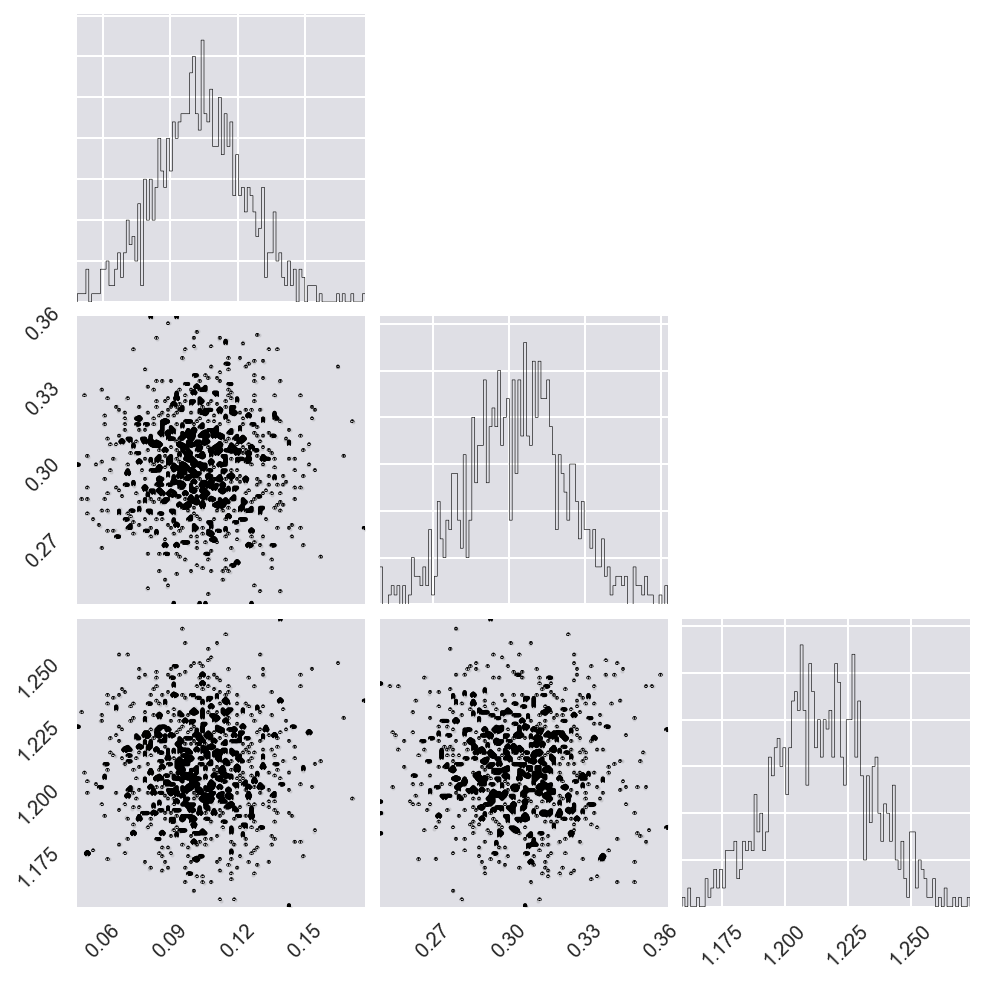

In [184]:
#before walk
fig = corner.corner(p0[:, 0:3], bins=100)

/Users/dangeles/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/dangeles/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


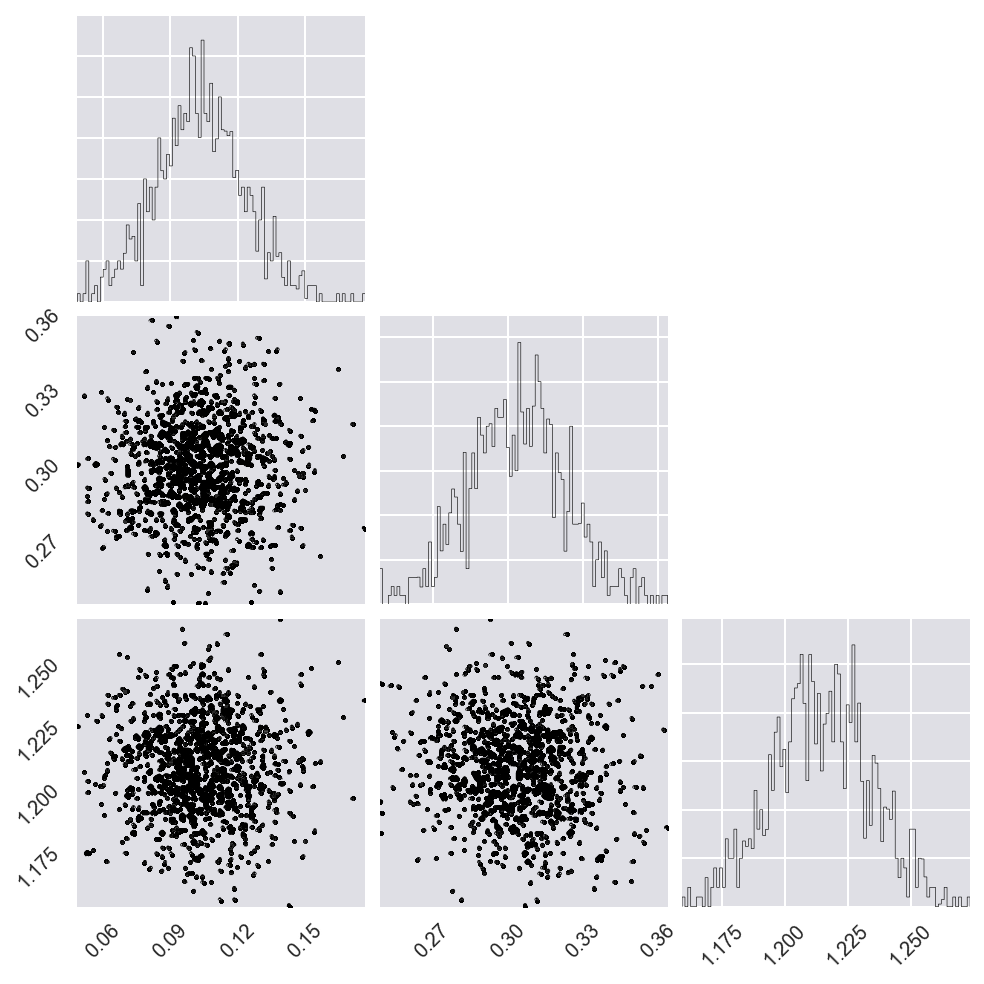

In [185]:
#after walk
fig = corner.corner(sampler.flatchain[:, 0:3], bins=100)

/Users/dangeles/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/dangeles/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


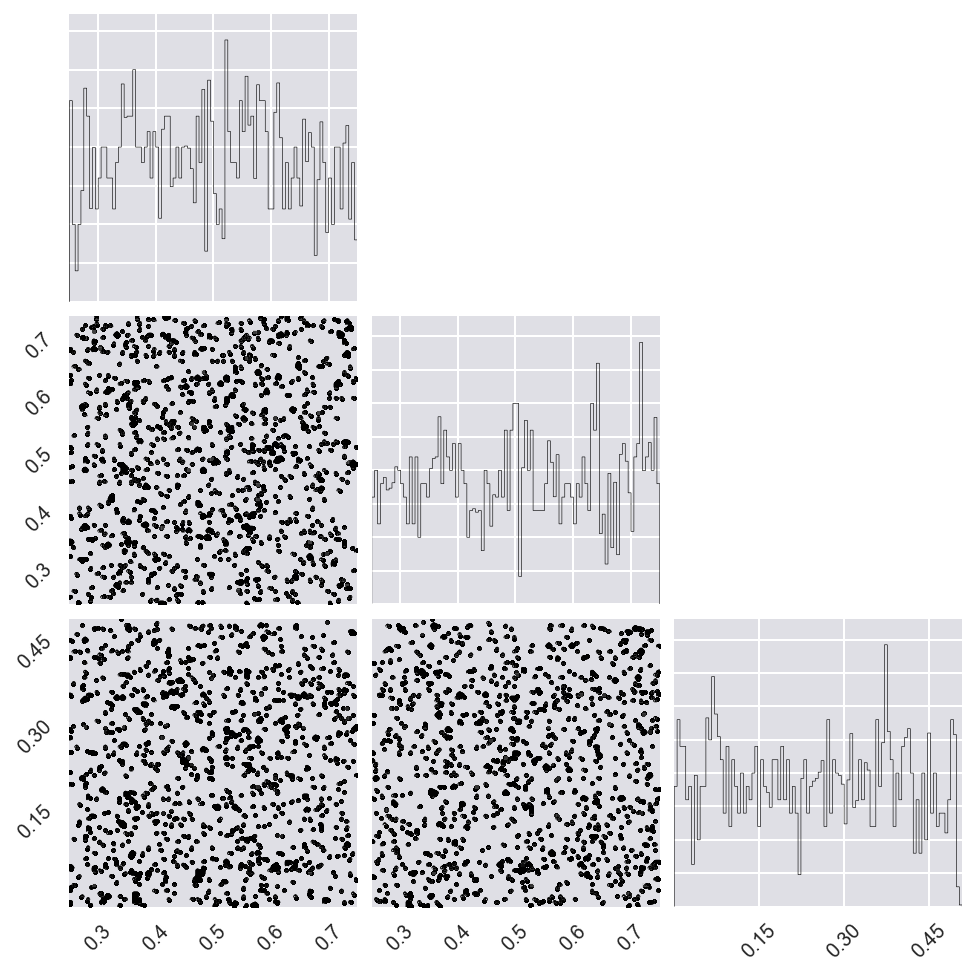

In [186]:
fig = corner.corner(sampler.flatchain[:, 3:6], bins=100)

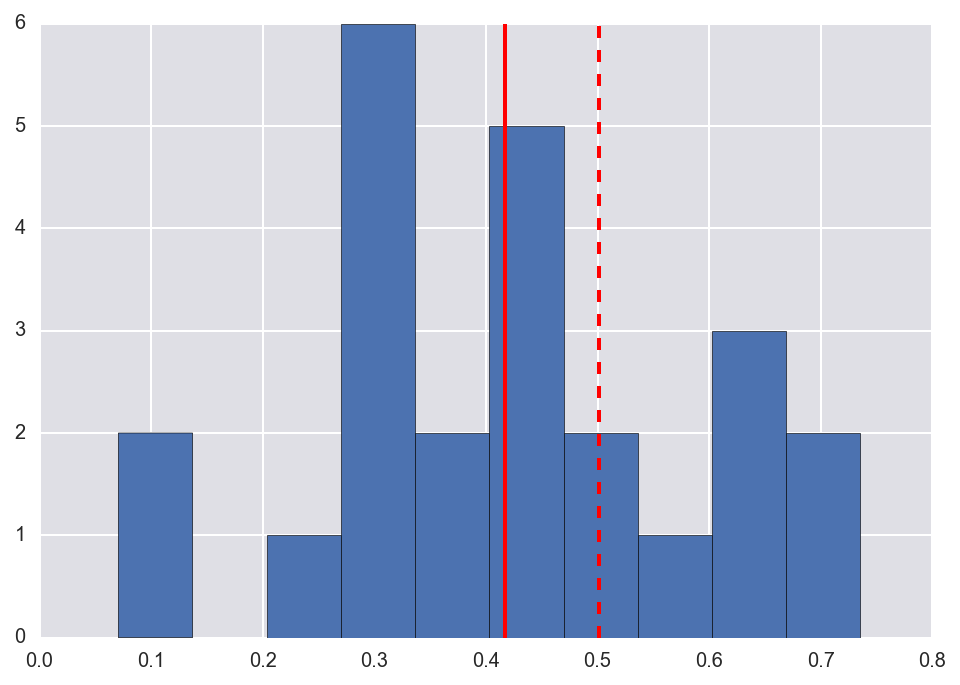

In [187]:
x = 1/2
# outliers = s >= s.mean() + x*s.std()
outliers = s > 0.5

plt.hist(s)
plt.axvline(s.mean(), color='r')
plt.axvline(s.mean()+ x*s.std(), ls='--', color='r')

In [188]:
# mean, sigma, sem= fetch_params(sampler)

# print("""
# mean: {0:2f} +/- {1:2f}
# sigma:     {2:2f}
# """.format(mean, sem, sigma))
# g = sampler.flatchain[:, 3:].mean(axis=0)

# Identify outliers

# sns.swarmplot(x='gene', y='z_dead', , data=df)
# plt.xticks(rotation=90)

In [189]:
def outy(x, array=outliers):
    ind = np.where(df.gene.unique() == x)
    return array[ind][0]
df['outliers'] = df.gene.apply(lambda x: outy(x))
df['mean_mcmc'] = df.gene.apply(lambda x: outy(x, array=means))

# sns.swarmplot(x='gene', y='z_dead', hue='outliers', size=10, data=df)
# plt.xticks(rotation=90)

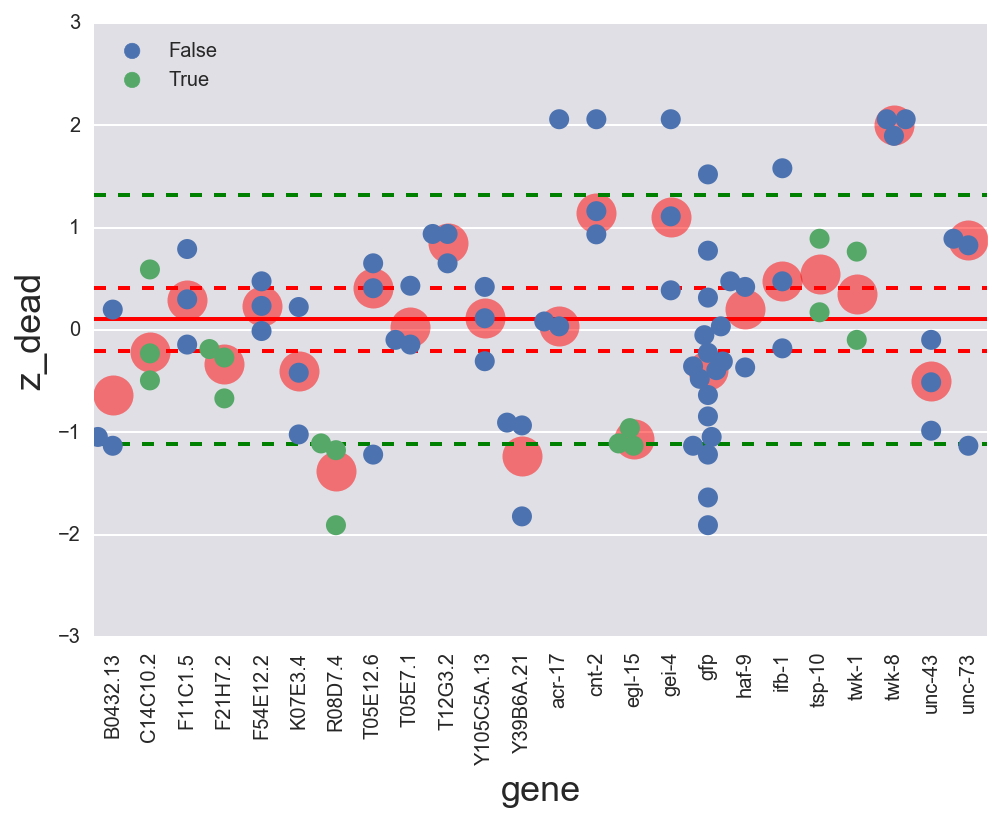

In [190]:
mean = sampler.flatchain[:, 0].mean()
sigma = sampler.flatchain[:, 1].mean()
sigma_bad = sampler.flatchain[:, 2].mean()


sns.swarmplot(x='gene', y='z_dead', hue='outliers', size=10, data=df)
plt.plot(means, 'o', alpha=0.5, ms=20, color='r')
plt.axhline(mean, color='r')
plt.axhline(mean-sigma, color='r', ls='--')
plt.axhline(mean+sigma, color='r', ls='--')
plt.axhline(mean-sigma_bad, color='g', ls='--')
plt.axhline(mean+sigma_bad, color='g', ls='--')

plt.xticks(rotation=90)
plt.legend(loc='upper left')

/Users/dangeles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


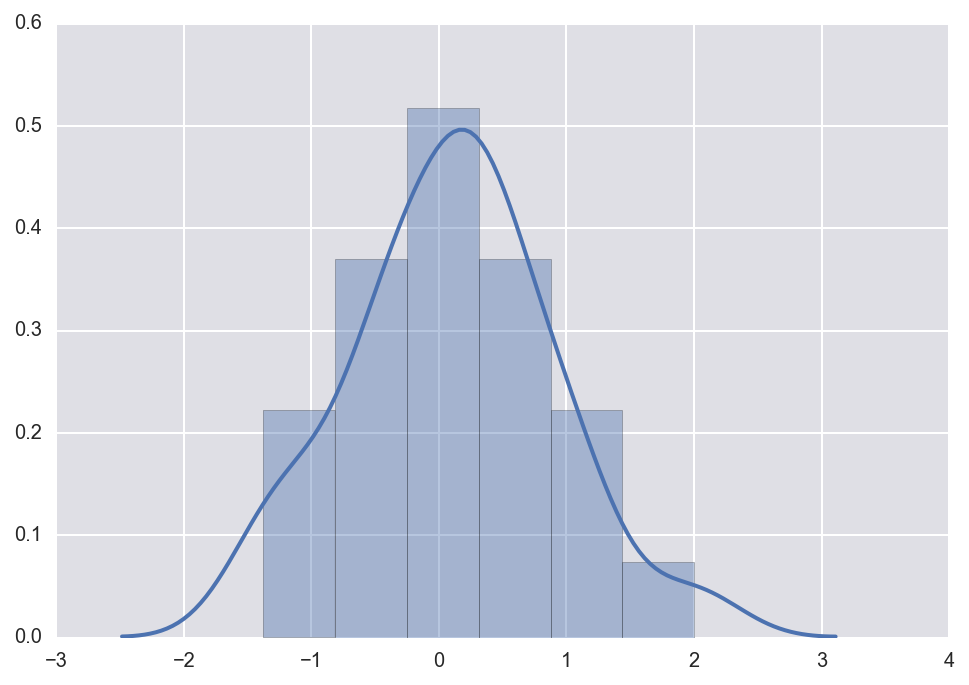

In [191]:
sns.distplot(df.mean_mcmc.unique())

In [192]:
(means - means.mean())/means.var()

array([-1.23601857, -0.53741113,  0.31447053, -0.72255129,  0.21724127,
       -0.83947491, -2.45692655,  0.50183497, -0.12207314,  1.23447369,
        0.01253396, -2.21977183, -0.11494675,  1.7224438 , -1.94601073,
        1.65779486, -0.816311  ,  0.1656572 ,  0.62178091,  0.7370374 ,
        0.41479461,  3.14053702, -1.00764032,  1.27853599])

(array([ 1.,  1.,  3.,  2.,  4.,  2.,  2.,  2.,  0.,  1.]),
 array([-1.23295255, -0.90945827, -0.58596398, -0.2624697 ,  0.06102459,
         0.38451887,  0.70801316,  1.03150744,  1.35500173,  1.67849601,
         2.0019903 ]),
 <a list of 10 Patch objects>)

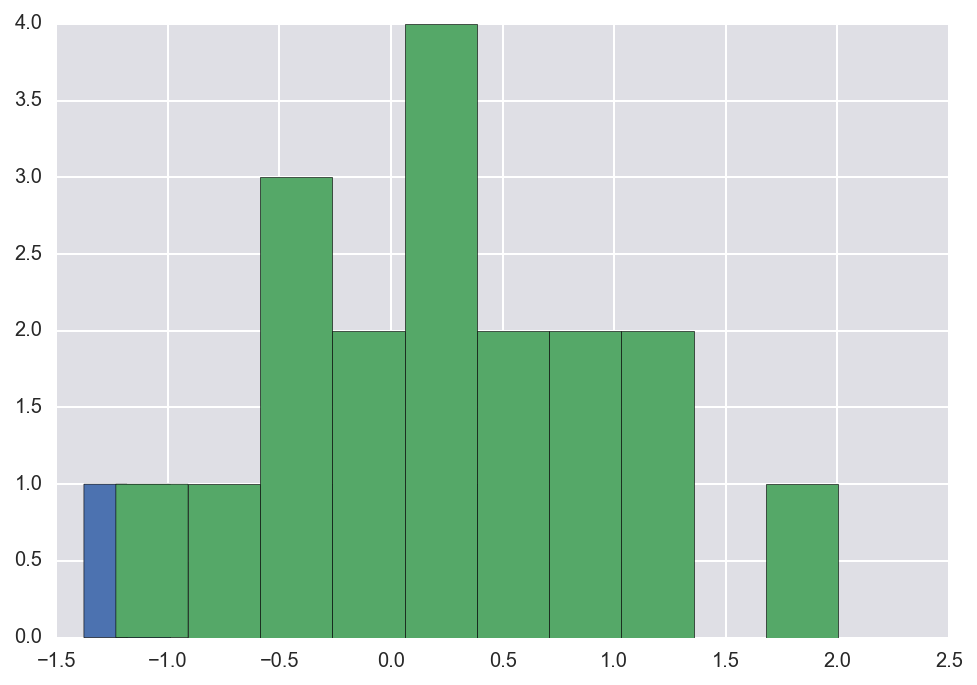

In [194]:
plt.hist(means[outliers])
plt.hist(means[~outliers])

In [195]:
p0[0, locs_means][-6]

0.45535999636431901